<br/>

<!-- <p style="text-align:center;font-weight:bold;font-size:400%">Model-Free Prediction - Part 2</p> -->
<img src="assets/title_part2.png"/>

# Introduction

Part II of algorithms presented in Lecture 4 of UCL RL course by David Silver. Part I is [here](ModelFreePrediction_Part1.ipynb).

In part I we explored some basic MC and TD algorithms. Both MC and TD are just special cases of broader class of algorithms, which we will implement in this notebook.

Notes:
* As in Part I, we are doing fixed-policy evaluation, no policy improvement
* Note that only Backward View TD(λ) is applicable in real world. N-Step and Forward TD(λ) are extremely slow.

Contents:
* Intro
  * [Introduction](#Introduction) - this section
  * [1D Corridor](#1D-Corridor) - environment
  * [Helper Functions](#Helper-Functions)
* Algorithms:
  * [Running-Mean Monte-Carlo](#Running-Mean-Monte-Carlo) - same as in Part 1
  * [Temporal-Difference Learning](#Temporal-Difference-Learning) - same as in Part 1, offline version
  * [N-Step Return](#N-Step-Return) - extension of TD to n-steps, offline version
  * [Forward View TD(λ)](#Forward-View-TD(λ%29) - offline version
  * [Backward View TD(λ)](#Backward-View-TD(λ%29) - offline, aka eligibility traces
* Online Implementations
  * [Online TD](#Online-TD) - online version of basic TD
  * [Online TD(λ)](#Online-TD(λ%29) - online version of TD(λ)
* Bonus:
  * [Proof for λ-return with finite time-horizon](#Proof-for-λ-return-with-finite-time-horizon)

Sources:
* UCL Course on RL: http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html
  * Lecture 4 pdf: http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/MC-TD.pdf
  * Lecture 4 vid: https://www.youtube.com/watch?v=PnHCvfgC_ZA


# 1D Corridor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

Blackjack environment is all good, but it allows for trajectories max 2-3 steps long. To better demonstrate N-Step and TD(λ) we will need environment that is still simple, but allows for longer trajectories. As per lectures we will use a 1D corridor.

<img src="assets/corridor.png"/>

There are 21 possible states:
* 0 - left-side terminal state
* 1-9 normal states
* 10 - start state
* 11-19 - normal
* 20 - right-side terminal state

The code below defines simple corridor environment. It tries to be compatible with OpenAI Gym API.

In [2]:
class LinearEnv:
    """
    Allowed states are:
    State id: [ 0 ... 10 ... 20 ]
    Type:     [ T ...  S ...  T ]
    Reward:   [-1  0   0  0   1 ]
    """
    def __init__(self):
        size = 19
        self._max_left = 1      # last non-terminal state to the left
        self._max_right = size  # last non-terminal state to the right
        self._start_state = (size // 2) + 1
        self.reset()

    def reset(self):
        self._state = self._start_state
        self._done = False
        return self._state

    def step(self, action):
        if self._done: return (self._state, 0, True)  # We are done
        if action not in [-1, 1]: raise ValueError('Invalid action')

        self._state += action
        obs = self._state
        if self._state > self._max_right:
            reward = +1
            self._done = True
        elif self._state < self._max_left:
            reward = -1
            self._done = True
        else:
            reward = 0
            self._done = False
        return (obs, reward, self._done)

Let's establish some ground truth reference for random policy.

In [3]:
GROUND_TRUTH = np.arange(-20, 22, 2) / 20.0
GROUND_TRUTH[0] = GROUND_TRUTH[-1] = 0
GROUND_TRUTH

array([ 0. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
        0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  0. ])

Finally, let's create environment and some helper variables. Dictionaries are used to keep data for plotting.

In [4]:
env = LinearEnv()
obs_shape = [21]

# Helper Functions

Let's get helper functions out of the way.

In [5]:
def generate_episode():
    """Generate one complete episode"""
    trajectory = []
    done = True
    while True:
        # === time step starts ===
        if done:
            obs, reward, done = env.reset(), None, False
        else:
            obs, reward, done = env.step(action)   
        action = np.random.choice([-1, 1])
        trajectory.append((obs, reward, done, action))
        if done:
            break
        # === time step ends here ===
    return trajectory

Across this notebook, we will compare performance of different algorithms. Every time we run an expeiment, we will create new entry in V_dict and E_dict. Key will be string e.g. "td red 1", where first word is name of algorithm, second word is colour of a plot, third is experiment number.

* __V_dict__ holds 1d state-value array after policy evaluation is completed
* __E_dict__ holds 1d array, where each entry is root-mean-square-error between state-value estimate and ground truth calculated after every episode

In [6]:
# OrderedDict() so plots are plotted in order
V_dict = OrderedDict()  # final state-values
E_dict = OrderedDict()  # root-mean-squared-error

def plot_all_experiments():
    fig = plt.figure(figsize=[18,6])
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.plot(GROUND_TRUTH[1:-1], color='gray')
    for key in V_dict.keys():
        ax1.plot(V_dict[key][1:-1], color=str.split(key)[1], alpha=0.4)
        ax2.plot(E_dict[key], color=str.split(key)[1], alpha=0.1)

    ax1.grid()
    ax1.set_title('Estimated State-Values')
    ax2.grid()
    ax2.set_title('Ground Truth Error')
    plt.show()

# Running-Mean Monte-Carlo

We will compare all algorithms in offline versions first. This makes code more similar. Implementation of online versions is included at the end of the post.

We will follow same patter for all algorithms:
* First, wrap experiment into function
* Call multiple times to gather data

MC and TD algorithms are the same as in previous post. They are presented here again as reference.

In [7]:
def mc_experiment(N, alpha):
    hist = []
    V = np.zeros(obs_shape)
    for ep in range(N):
        trajectory = generate_episode()
        Gt = trajectory[-1][1]  # shortcut (see note in part 1)
        for St, _, _, _ in trajectory[:-1]:
            V[St] = V[St] + alpha * (Gt - V[St])
        hist.append(V.copy())
    return np.array(hist)

We are doing only 50 steps of evaluation to exaggerate difference between algorithms

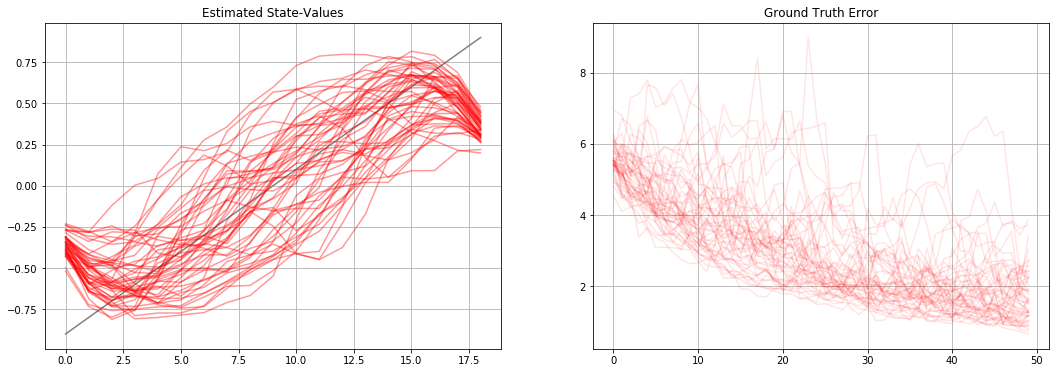

In [8]:
for run_nb in range(50):
    hist = mc_experiment(N=50, alpha=0.01)
    V_dict['mc red '+str(run_nb)] = hist[-1]
    E_dict['mc red '+str(run_nb)] = np.sum((GROUND_TRUTH - hist)**2, axis=-1)

plot_all_experiments()

# Temporal-Difference Learning
Applied offline for better consistency with algorithms. As with MC, this algorithm was presented in previous part so we won't dwell in detail.

In [9]:
def td_experiment(N, alpha):
    hist = []
    V = np.zeros(obs_shape)
    for ep in range(N):
        trajectory = generate_episode()
        for t in range(len(trajectory)-1):
            St, _, _, _ = trajectory[t]
            St_1, Rt_1, _, _ = trajectory[t+1]
            V[St] = V[St] + alpha * (Rt_1 + 1.0*V[St_1] - V[St])
        hist.append(V.copy())
    return np.array(hist)

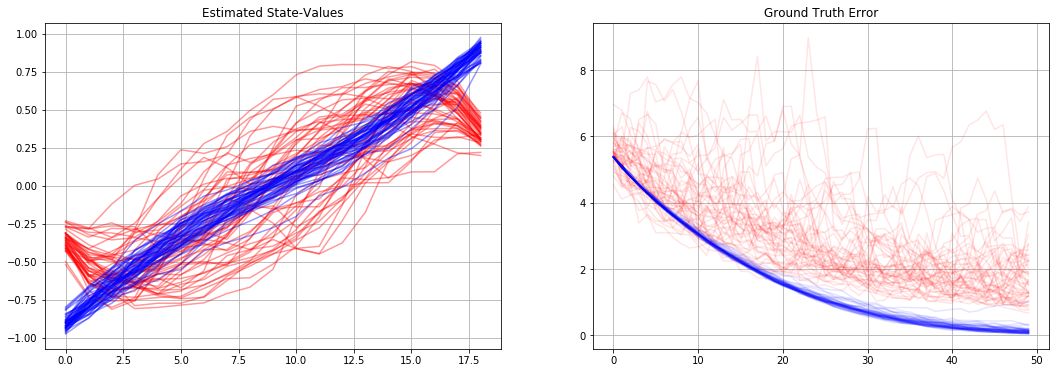

In [10]:
for run_nb in range(50):
    hist = td_experiment(N=50, alpha=0.2)
    V_dict['td blue '+str(run_nb)] = hist[-1]
    E_dict['td blue '+str(run_nb)] = np.sum((GROUND_TRUTH - hist)**2, axis=-1)

plot_all_experiments()

Clearly, TD is has dramatically lower variance. And is more efficient.

# N-Step Return

Here is where all the fun begins. We need to be able to calculate $G_t^{(n)}$ for any n. For example, n=3 will back up 3-steps and $V(S_{t+3})$

<img src="assets/nstep.png">

Firstly, we have been hacking the way we were computing return $ G_t $ so far.
* In case of MC - we noticed that with discount $ \gamma = 1 $ and all reward received in terminal state we can simplify $ G_t = R_{t+1} + \gamma R_{t+2} + ... $ to $ G_t = R_{t=T} $
* In case of TD - there was no need to calculate full return $ G_t $

For N-Step, and Forward TD(λ) algorithms we will need to calculate n-step return $ G_t^{(n)} $ at each time step. We will no longer hack it, instead we introduce function that, give full trajectory, can compute $ G_t^{(n)} $ correctly. From the lectures:

$$ G_t^{(n)} = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... + \gamma^n V(S_{t+n}) $$

Inputs to our function are as follows:
* __trajectory__ - a list of tuples, one for each time step. Each tuple is (obs, reward, done, act):
  * observation [int] - state visited at time step t
  * reward [float] - reward received at time step t
  * done [bool] - is time step t terminal? (this is unused, but useful for debug)
  * action [int] - action picked by agent, -1 or 1
* __V__ - 1d array of float, current estimates of state-values, terminal states must have value 0
* __t__ - time step to evaluate
* __disc__ - discount rate, usually denoted as γ, in this particular case it's 1 anyways
* __nstep__ - number of steps to include in return $G_t^{(n)}$. It is possible to pass float('inf') as nstep, in such case function will compute $G_t$ instead (including all steps in trajectory, disregarding of trajectory length).

In [11]:
def calc_Gt(trajectory, V, t, disc, nstep=float('inf')):
    """Calculates return for state t, using n future steps.
    Params:
        traj - complete trajectory, each time-step should be tuple:
            (observation, reward, done, action)
        V (float arr) - state-values, V[term_state] must be zero!
        t (int [t, T-1]) - calc Gt for this time step in trajectory,
            0 is initial state; T-1 is last non-terminal state
        disc - discrount, usually noted as gamma
        n (int or +inf, [1, +inf]) - n-steps of reward to accumulate
                If n >= T then calculate full return for state t
                For n == 1 this equals to TD return
                For n == +inf this equals to MC return
    """

    T = len(trajectory)-1   # terminal state
    max_j = min(t+nstep, T) # last state iterated, inclusive
    tmp_disc = 1.0          # this will decay with rate disc
    Gt = 0                  # result

    # Iterate from t+1 to t+nstep or T (inclusive on both start and finish)
    for j in range(t+1, max_j+1):
        Rj = trajectory[j][1]  # traj[j] is (obs, reward, done, action)
        Gt += tmp_disc * Rj
        tmp_disc *= disc

    # Note that V[Sj] will have state-value of state t+nstep or
    # zero if t+nstep >= T as V[St=T] must equal 0
    Sj = trajectory[j][0]  # traj[j] is (obs, reward, done, action)
    Gt += tmp_disc * V[Sj]

    return Gt

Run experiment exactly as before, replace target with Gt

In [12]:
def nstep_experiment(N, alpha, nstep):
    hist = []
    V = np.zeros(obs_shape)

    for ep in range(N):
        trajectory = generate_episode()
        for t in range(len(trajectory)-1):  # never evaluate terminal states (see note #3)
            St, _, _, _ = trajectory[t]
            Gt = calc_Gt(trajectory, V, t, disc=1.0, nstep=nstep)
            V[St] = V[St] + alpha * (Gt - V[St])
        hist.append(V.copy())
    return np.array(hist)

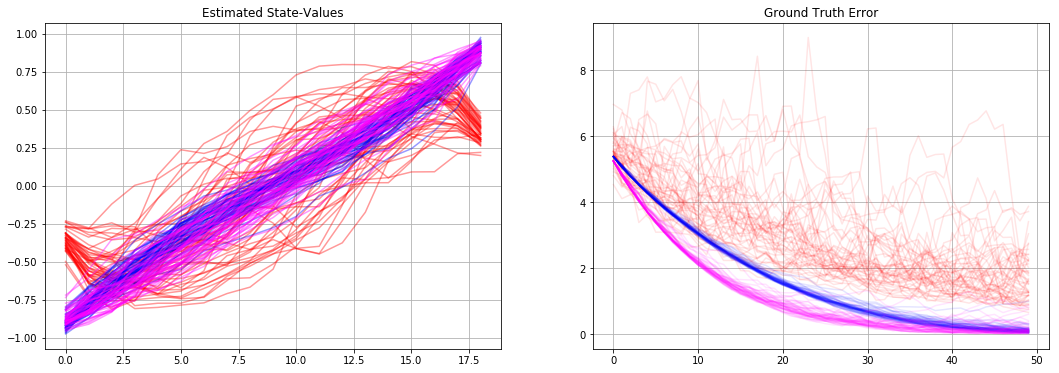

In [13]:
for run_nb in range(50):
    # hist = nstep_experiment(N=50, alpha=0.01, nstep=float('inf'))  # same as MC
    # hist = nstep_experiment(N=50, alpha=0.2, nstep=1)              # same as TD
    hist = nstep_experiment(N=50, alpha=0.1, nstep=3)    # tune for best result
            
    V_dict['nstep magenta '+str(run_nb)] = hist[-1]
    E_dict['nstep magenta '+str(run_nb)] = np.sum((GROUND_TRUTH - hist)**2, axis=-1)

plot_all_experiments()

# Forward View TD(λ)

<img src="assets/fwd_cartoon.png">

Even more fun with TD(λ)! As concepts are well explained in David Silver lectures I won't repeat it here. Basically we are going to replace target from $G_t^{(n)}$ to $G_t^\lambda$.

Let's bring some diagrams from the lectures

<img src="assets/fwd_decay.png">

And equation

$$ G_t^\lambda = (1-\lambda)\sum_{n=1}^{\infty}\lambda^{n-1}G_t^{(n)} $$

which is same as

$$G_t^\lambda = (1-\lambda)\sum_{n=1}^{T-t-1}\left[ \lambda^{n-1}G_t^{(n)} \right] + \lambda^{T-t-1}G_t$$

If above transition looks a bit furry, see extended proof in the appendix at the end.

Note that we are truncating computation when lambda becomes too small. This speeds up computation a lot.

In [14]:
def lambda_fwd_experiment(N, alpha, lmbda):
    hist = []
    V = np.zeros(obs_shape)

    for ep in range(N):
        trajectory = generate_episode()
        for t in range(len(trajectory)-1):
            lambda_trunctuate = 1e-3  # optional optimization
            St, _, _, _ = trajectory[t]
            Gt_lambda = 0
            T = len(trajectory)-1  # terminal state
            max_n = T-t-1          # inclusive
            
            # Left-hand side of equation
            lmbda_iter = 1         # decays with rate lmbda
            for nstep in range(1, max_n+1):
                Gtn = calc_Gt(trajectory, V, t, disc=1.0, nstep=nstep)
                Gt_lambda += lmbda_iter * Gtn
                lmbda_iter *= lmbda
                if lmbda_iter < lambda_trunctuate:  # optional optimization
                    break                           # optional optimization
            Gt_lambda *= (1 - lmbda)
            
            # Right-hand side of equation
            if lmbda_iter >= lambda_trunctuate:                                # "if" is optional
                Gt_lambda += lmbda_iter * calc_Gt(trajectory, V, t, disc=1.0)  # but this stays!
            
            V[St] = V[St] + alpha * (Gt_lambda - V[St])
            
        hist.append(V.copy())
    return np.array(hist)

This will take couple seconds at least (over 30sec w/o lambda trunctuation)

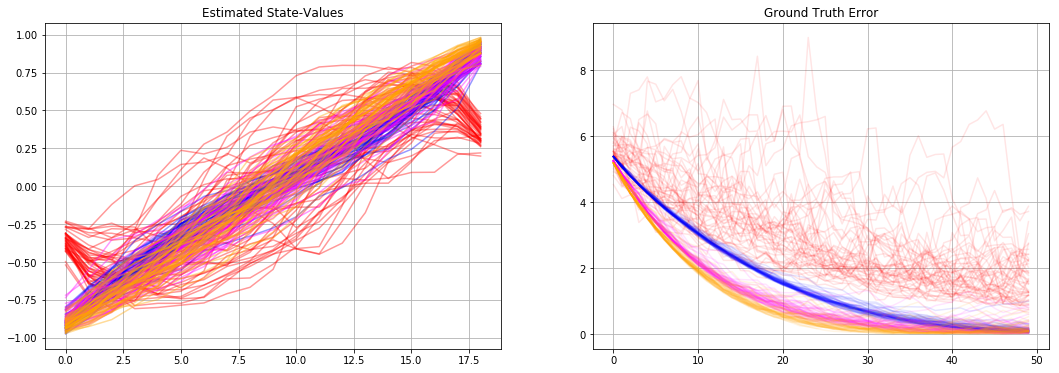

In [15]:
for run_nb in range(50):
    # hist = lambda_fwd_experiment(N=100, alpha=0.01, lmbda=1)  # same as MC, slow!
    # hist = lambda_fwd_experiment(N=100, alpha=0.2, lmbda=0)   # same as TD
    hist = lambda_fwd_experiment(N=50, alpha=0.2, lmbda=0.4)  # tiny better than n-step?
            
    V_dict['lambda orange '+str(run_nb)] = hist[-1]
    E_dict['lambda orange '+str(run_nb)] = np.sum((GROUND_TRUTH - hist)**2, axis=-1)

plot_all_experiments()

# Backward View TD(λ)

<img src="assets/bw_cartoon.png">

As before, let's bring in equations from lectures as reference

$ \quad\quad E_0(s) = 0 $

$ \quad\quad E_t(s) = \gamma \lambda E_{t-1}(s) + \mathbf{1}(S_t=s) $

$ \quad\quad \rho_t = R_{t+1} + \gamma V(S_{t+1}) - V(S_t) $

$ \quad\quad V(s) = \leftarrow V(s) + \alpha \rho_t E_t(s) $

If updates were to accumulated and performed once after the episode above would be equivalent to Forward TD(λ). Note that even though we are performing updates offline, we are _not_ accumulating updates in either case, so I'm not sure if exact equivalence holds in this particular implementation.

If you are given equations, implementation is not too difficult

In [16]:
def eltrace_experiment(N, alpha, lmbda):
    hist = []
    V = np.zeros(obs_shape)
    E = np.zeros(obs_shape)  # eligibility traces
    
    for ep in range(N):
        E *= 0                              # reset every new episode
        trajectory = generate_episode()
        for t in range(len(trajectory)-1):  # never evaluate terminal states (see note #3)
            St, _, _, _ = trajectory[t]
            St_1, Rt_1, _, _ = trajectory[t+1]
                        
            E *= lmbda  # decay
            E[St] += 1  # increment
                        
            ro_t = Rt_1 + 1.0 * V[St_1] - V[St]            
            V += alpha * ro_t * E
        
        hist.append(V.copy())
    return np.array(hist)

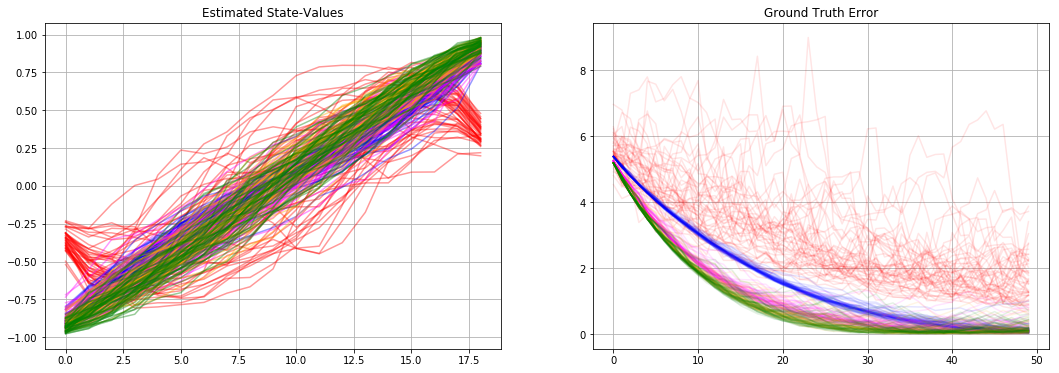

In [17]:
for run_nb in range(50):
    # hist = eltrace_experiment(N=100, alpha=0.01, lmbda=1)  # same as MC
    # hist = eltrace_experiment(N=100, alpha=0.2, lmbda=0)  # same as TD
    hist = eltrace_experiment(N=50, alpha=0.2, lmbda=0.4)
            
    V_dict['eltrace green '+str(run_nb)] = hist[-1]
    E_dict['eltrace green '+str(run_nb)] = np.sum((GROUND_TRUTH - hist)**2, axis=-1)

plot_all_experiments()

# Online TD

Normally, TD and Backward TD(λ) would be implemented online. This section provides simple reference implementation of both.

Let's clear the graphs for clarity.

In [18]:
V_dict = OrderedDict()  # final state-values
E_dict = OrderedDict()  # root-mean-squared-error

This is the same as TD from part 1 post

In [19]:
def td_online_experiment(N, alpha):
    hist = []
    V = np.zeros(obs_shape)
    for ep in range(N):
        trajectory = []
        done = True
        while True:
            # === time step starts ===
            if done:
                obs, reward, done = env.reset(), None, False
            else:
                obs, reward, done = env.step(action)
            # perform TD update from the perspective of previous step
            # PREVIOUS STEP is t, CURRENT STEP is t+1
            if len(trajectory) >= 2:  # 
                St, _, _, _ = trajectory[-1]
                St_1, Rt_1 = obs, reward
                V[St] = V[St] + alpha * (Rt_1 + V[St_1] - V[St])

            action = np.random.choice([-1, 1])
            trajectory.append((obs, reward, done, action))
            if done: break
            # === time step ends here ===
        hist.append(V.copy())
    return np.array(hist)

In [20]:
for run_nb in range(50):
    hist = td_online_experiment(N=50, alpha=0.2)
    V_dict['td blue '+str(run_nb)] = hist[-1]
    E_dict['td blue '+str(run_nb)] = np.sum((GROUND_TRUTH - hist)**2, axis=-1)

# plot_all_experiments()

 # Online TD(λ)

In [21]:
def eltrace_online_experiment(N, alpha, lmbda):
    hist = []
    V = np.zeros(obs_shape)
    E = np.zeros(obs_shape)
    for ep in range(N):
        E *= 0
        trajectory = []
        done = True
        while True:
            # === time step starts ===
            if done:
                obs, reward, done = env.reset(), None, False
            else:
                obs, reward, done = env.step(action)
            
            # perform TD update from the perspective of previous step
            # PREVIOUS STEP is t, CURRENT STEP is t+1
            if len(trajectory) >= 2:  # 
                St, _, _, _ = trajectory[-1]
                St_1, Rt_1 = obs, reward
                E *= lmbda  # decay
                E[St] += 1  # increment
                ro_t = Rt_1 + 1.0 * V[St_1] - V[St]            
                V += alpha * ro_t * E
                # V[St] = V[St] + alpha * (Rt_1 + V[St_1] - V[St])

            action = np.random.choice([-1, 1])
            trajectory.append((obs, reward, done, action))
            if done: break
            # === time step ends here ===
        hist.append(V.copy())
    return np.array(hist)

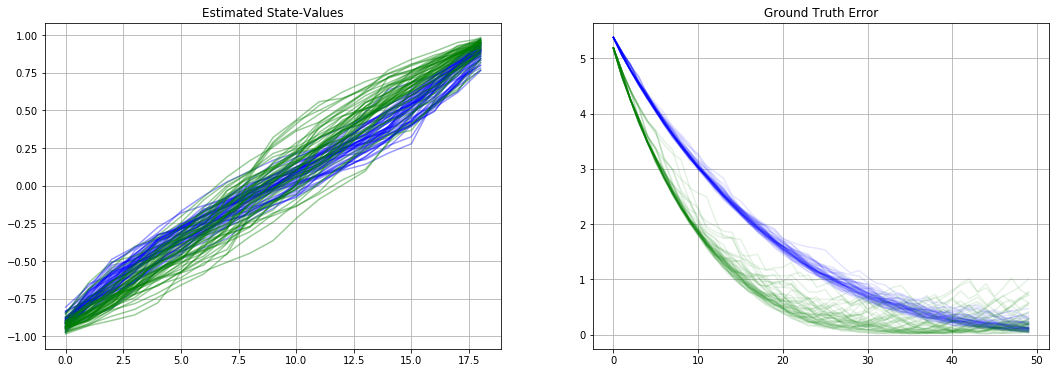

In [22]:
for run_nb in range(50):
    # hist = eltrace_online_experiment(N=100, alpha=0.01, lmbda=1)  # same as MC
    # hist = eltrace_online_experiment(N=100, alpha=0.2, lmbda=0)  # same as TD
    hist = eltrace_online_experiment(N=50, alpha=0.2, lmbda=0.4)
            
    V_dict['eltrace green '+str(run_nb)] = hist[-1]
    E_dict['eltrace green '+str(run_nb)] = np.sum((GROUND_TRUTH - hist)**2, axis=-1)

plot_all_experiments()

# Proof for λ-return with finite time horizon

$ G_t^\lambda = (1-\lambda) \sum_{n=1}^{\infty} \lambda^{n-1} G_t^{(n)} = $

Because $G_t^{(n)} = G_t$ if n is large enough to "go over" episode length

$ (1-\lambda) \sum_{n=1}^{T-t-1} \left[ \lambda^{n-1} G_t^{(n)} \right] +
(1-\lambda) \sum_{n=T-t}^{\infty} \lambda^{n-1} \color{blue}{ G_t^{(n)} } \color{black} = $

$ (1-\lambda) \sum_{n=1}^{T-t-1} \left[ \lambda^{n-1} G_t^{(n)} \right] +
(1-\lambda) \sum_{n=T-t}^{\infty} \lambda^{n-1} \color{blue}{ G_t } \color{black} = $

Now let's substitute
$ n = n'+T-t-1 \ \rightarrow \ n'=1 $

$ (1-\lambda) \sum_{n=1}^{T-t-1} \left[ \lambda^{n-1} G_t^{(n)} \right] +
(1-\lambda) \sum_{n'=1}^{\infty} \lambda^{n'+T-t-1-1} G_t = $

Break down λ

$ (1-\lambda) \sum_{n=1}^{T-t-1} \left[ \lambda^{n-1} G_t^{(n)} \right] +
(1-\lambda) \sum_{n'=1}^{\infty} \lambda^{n'-1} \lambda^{T-t-1} G_t = $

And take before sum

$ (1-\lambda) \sum_{n=1}^{T-t-1} \left[ \lambda^{n-1} G_t^{(n)} \right] +
\lambda^{T-t-1} G_t (1-\lambda) \sum_{n'=1}^{\infty} \lambda^{n'-1} = $

From sum of infinite geometric series we get

$ (1-\lambda) \sum_{n=1}^{T-t-1} \left[ \lambda^{n-1} G_t^{(n)} \right] +
\lambda^{T-t-1} G_t (1-\lambda) \color{blue}{ \sum_{n'=1}^{\infty} \lambda^{n'-1} } \color{black} = $

$ (1-\lambda) \sum_{n=1}^{T-t-1} \left[ \lambda^{n-1} G_t^{(n)} \right] +
 \lambda^{T-t-1} G_t (1-\lambda) \color{blue}{ \frac{1}{(1-\lambda)} }\color{black} = $

 $ (1-\lambda) \sum_{n=1}^{T-t-1} \left[ \lambda^{n-1} G_t^{(n)} \right] +
 \lambda^{T-t-1} G_t $
